En la primera celda del trabajo ubique los nombres de los integrantes del grupo de la siguiente forma:

- __Nombre y cédula del integrante 1 del grupo:__ Julián Alejandro Úsuga Ortiz 1001137545



- __Nombre y cédula del integrante 2 del grupo:__ Ivan Santiago Rojas Martinez


# Parcial 3

### Enunciados Punto 1

Considere las bases de datos del petróleo brent (con nombre __petroleo_brent_historico.csv__) y de la tasa representativa del mercado (__trm_historico.csv__) que se encuentran en la carpeta DATOS del Google Drive.

1. Lea ambas bases de datos.

2. Una las dos bases de datos en una sola BD.

3. Realice un gráfico donde aparezcan ambas series de tiempo.

4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.

7. Encuentre un modelo con la función __auto_arima__ para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.

8. Realice un diagnóstico del modelo y saque conclusiones.

9. Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

10. Saque conclusiones.

## 1. Lea ambas bases de datos.

In [387]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
 
import pmdarima as pmd
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')

In [388]:
df = pd.read_csv("../data/petroleo_brent_historico.csv", decimal=",")
dolar = pd.read_csv("../data/trm_historico.csv")

In [389]:
df.Fecha = pd.to_datetime(df.Fecha, format="%d.%m.%Y")

In [390]:
df["fecha"] = df.Fecha
df["petroleo"] = df["Último"]

In [391]:
df = df[["fecha", "petroleo"]]

In [392]:
df.head()

,fecha,petroleo
0,2022-03-14,106.90
1,2022-03-11,112.67
2,2022-03-10,109.33
3,2022-03-09,111.14
4,2022-03-08,127.98


In [393]:
dolar.head()

,VALOR,UNIDAD,VIGENCIADESDE,VIGENCIAHASTA
0,2850.98,COP,09/10/2002,09/10/2002
1,2854.04,COP,10/10/2002,10/10/2002
2,2870.63,COP,11/10/2002,11/10/2002
3,2861.16,COP,12/10/2002,15/10/2002
4,2852.99,COP,16/10/2002,16/10/2002


In [394]:
dolar["fecha"] = pd.to_datetime(dolar.VIGENCIADESDE, format="%d/%m/%Y")
dolar["dolar"] = dolar.VALOR

In [395]:
dolar = dolar[["fecha", "dolar"]]

## 2. Una las dos bases de datos en una sola BD.

In [396]:
df = df.merge(dolar, on='fecha', how='left')
df = df.dropna()

In [397]:
df = df.sort_values(by=['fecha'])

## 3. Realice un gráfico donde aparezcan ambas series de tiempo.

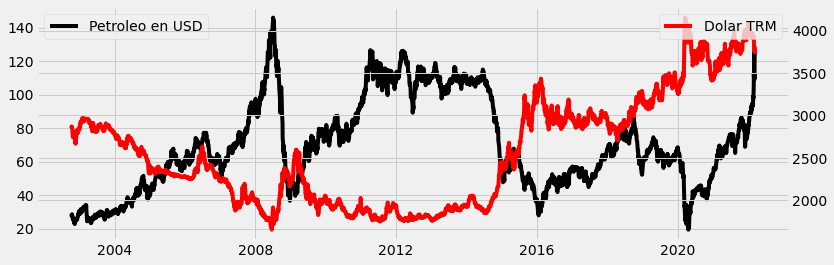

In [398]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()
ax1.plot(df.fecha, df.petroleo, color="black", label="Petroleo en USD")
ax2.plot(df.fecha, df.dolar, color="red", label="Dolar TRM")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

## 4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

In [399]:
import statsmodels.api as sm

In [400]:
df_2 = df.copy()

In [403]:
df_2["tendencia"] = list(range(0, 3636 + 1))

In [404]:
df_2["mes"] = df.fecha.dt.month

In [405]:
df_2["lag12"] = df.dolar.diff(periods = 12)

In [406]:
df_2 = df_2.dropna()
mod_l = sm.OLS(df_2[["dolar"]], df_2[["tendencia", "mes", "lag12"]])

res = mod_l.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dolar   R-squared (uncentered):                   0.892
Model:                            OLS   Adj. R-squared (uncentered):              0.892
Method:                 Least Squares   F-statistic:                              9931.
Date:                Tue, 08 Nov 2022   Prob (F-statistic):                        0.00
Time:                        18:04:40   Log-Likelihood:                         -29668.
No. Observations:                3625   AIC:                                  5.934e+04
Df Residuals:                    3622   BIC:                                  5.936e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Se observa correlación entre el mes y la serie y no se presenta correlación de la serie con su valor 12 dias atras, por esta razon podria ser innecesario usar un Seasonal ARIMA.**

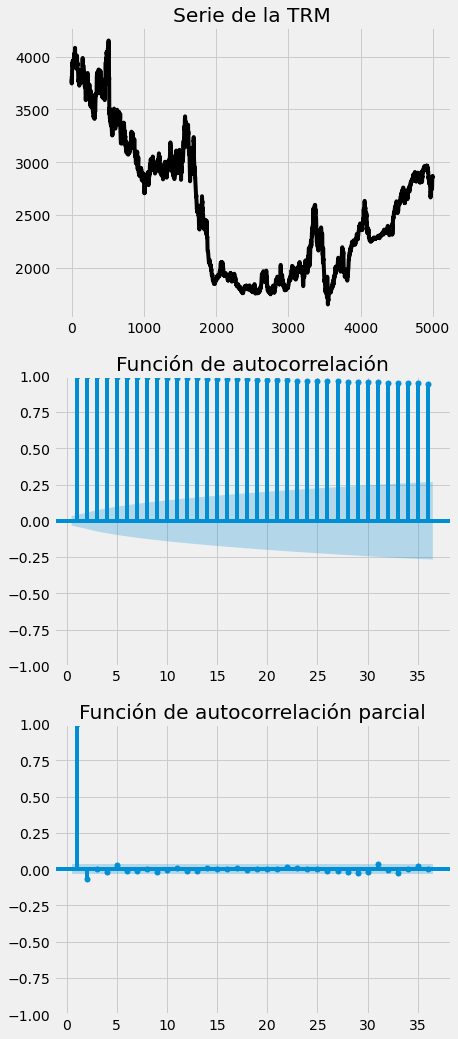

In [408]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
df.dolar.plot(ax=ax[0], title = "Serie de la TRM", xlabel="", color="black")
plot_acf(df.dolar, zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(df.dolar, method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

Del gráfico de la serie de tiempo no se observa que sea estacionaria, procedemos a observar la función de autocorrelación la cual presenta un decaimiento demasiado lento, por lo cual nos da indicios de que debemos de realizar una diferenciación.

Se realizará una prueba de Dickey-Fuller para verificar si es necesario realizar una diferenciación.

In [409]:
test = adfuller(df.dolar)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -0.4943040666
p-value: 	 	 0.8931232351189349


Observando el p-valor = 0.8931232351189345 y con una significancia de $\alpha = 0.05$ no se rechaza. Esto quiere decir que no hay estacionaridad en la serie, lo que nos indica que debemos realizar una diferenciación.

Procedemos a diferenciar la serie. 

In [410]:
dolar_diff = df.dolar.diff()
dolar_diff

4999      NaN
4998     3.06
4997    16.59
4994   -17.64
4993     4.14
        ...  
6      -91.18
4       41.64
3      -26.23
2      -40.75
1       39.57
Name: dolar, Length: 3637, dtype: float64

In [411]:
dolar_diff = dolar_diff[-dolar_diff.isna()]
dolar_diff

4998     3.06
4997    16.59
4994   -17.64
4993     4.14
4992    -3.23
        ...  
6      -91.18
4       41.64
3      -26.23
2      -40.75
1       39.57
Name: dolar, Length: 3636, dtype: float64

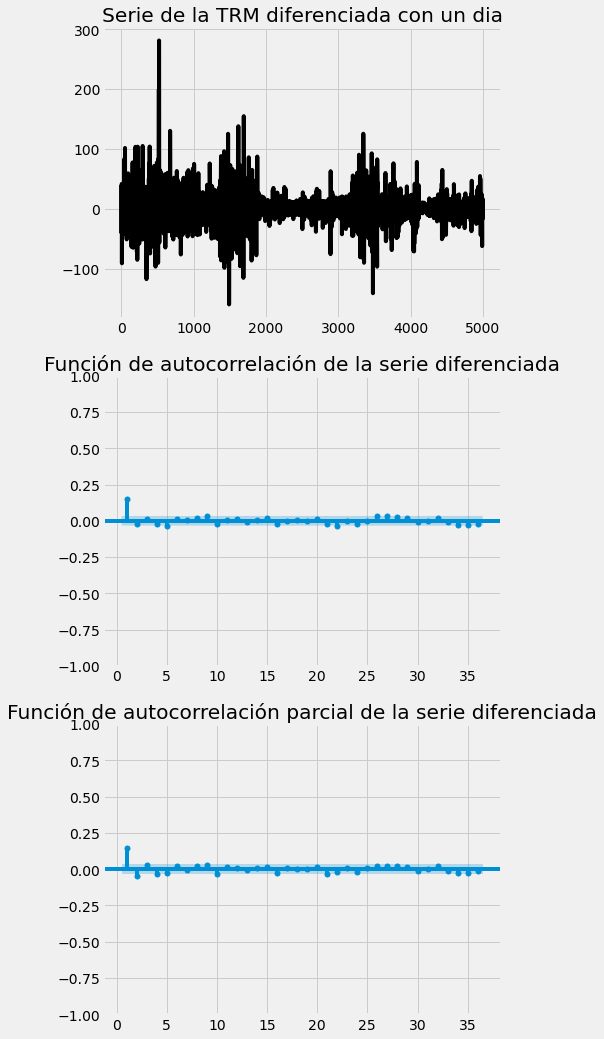

In [412]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
dolar_diff.plot(ax=ax[0], title = "Serie de la TRM diferenciada con un dia", xlabel="", color="black")
plot_acf(dolar_diff, zero = False, title = "Función de autocorrelación de la serie diferenciada", ax=ax[1])
plot_pacf(dolar_diff, method="ywm", zero = False, title = "Función de autocorrelación parcial de la serie diferenciada", ax=ax[2])
fig.show()

In [413]:
test = adfuller(dolar_diff)
printfuller(test)

Prueba de Dickey Fuller
The test statistic: 	 -27.498891546
p-value: 	 	 0.0


Observando el p-valor es menor a 0.05 por se rechaza la hipotesis nula. Esto quiere decir que hay estacionaridad en la serie con una diferenciación.

Despues de realizar la diferenciación se ve que en la ACF hay un corte en el Lag 1 y en la PACF hay un corte en el Lag 1 o 2, se entrenaran varios modelos.

In [414]:
pdq_l = [(p, 1, q) for p in [0, 1, 2, 3] for q in [0, 1, 2, 3]] # ARIMA(0:3, 1, 0:3)

In [415]:
filas = []
for order in pdq_l:
    fit = ARIMA(df.dolar, order=order).fit()
    aic = fit.aic
    bic = fit.bic
    filas.append([order, aic, bic])
filas

[[(0, 1, 0), 33295.1498032477, 33301.348442703],
 [(0, 1, 1), 33210.503851841735, 33222.90113075233],
 [(0, 1, 2), 33209.39997263503, 33227.99589100092],
 [(0, 1, 3), 33210.232801177845, 33235.02735899903],
 [(1, 1, 0), 33216.98773474664, 33229.38501365724],
 [(1, 1, 1), 33208.72846473918, 33227.32438310507],
 [(1, 1, 2), 33210.57747772448, 33235.37203554567],
 [(1, 1, 3), 33212.19433232851, 33243.187529605],
 [(2, 1, 0), 33211.57354238894, 33230.169460754834],
 [(2, 1, 1), 33210.53251436929, 33235.32707219048],
 [(2, 1, 2), 33212.7008982697, 33243.69409554619],
 [(2, 1, 3), 33190.79584411568, 33227.987680847466],
 [(3, 1, 0), 33211.12563695114, 33235.92019477233],
 [(3, 1, 1), 33212.05382796867, 33243.04702524516],
 [(3, 1, 2), 33214.53193918207, 33251.72377591385],
 [(3, 1, 3), 33210.302521184945, 33253.692997372025]]

Nos decidimos a usar el modelo p = 0, d = 1, q = 2 ya que es el que tiene mejor (AIC, BIC) y ademas no tiene muchos parametros.

In [416]:
df = df.reset_index(drop = True)

In [417]:
df

,fecha,petroleo,dolar
0,2002-10-09,28.13,2850.98
1,2002-10-10,27.74,2854.04
2,2002-10-11,27.99,2870.63
3,2002-10-16,28.58,2852.99
4,2002-10-17,27.97,2857.13
...,...,...,...
3632,2022-03-04,118.11,3771.77
3633,2022-03-08,127.98,3813.41
3634,2022-03-09,111.14,3787.18
3635,2022-03-10,109.33,3746.43


In [418]:
df_2[["dolar"]], df_2[["tendencia", "mes", "lag12"]]

(        dolar
 4983  2773.73
 4982  2778.60
 4979  2774.58
 4978  2761.99
 4977  2743.00
 ...       ...
 6     3771.77
 4     3813.41
 3     3787.18
 2     3746.43
 1     3786.00
 
 [3625 rows x 1 columns],
       tendencia  mes   lag12
 4983         12   10  -77.25
 4982         13   11  -75.44
 4979         14   11  -96.05
 4978         15   11  -91.00
 4977         16   11 -114.13
 ...         ...  ...     ...
 6          3632    3 -167.54
 4          3633    3 -104.34
 3          3634    3 -151.79
 2          3635    3 -200.45
 1          3636    3 -177.72
 
 [3625 rows x 3 columns])

In [419]:
fit = ARIMA(df.dolar, order=(0,1,2)).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  dolar   No. Observations:                 3637
Model:                 ARIMA(0, 1, 2)   Log Likelihood              -16601.700
Date:                Tue, 08 Nov 2022   AIC                          33209.400
Time:                        18:05:14   BIC                          33227.996
Sample:                             0   HQIC                         33216.024
                               - 3637                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1565      0.011     14.573      0.000       0.135       0.178
ma.L2         -0.0293      0.011     -2.790      0.005      -0.050      -0.009
sigma2       541.1635      5.127    105.559      0.000     531.115     551.212
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18711.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.92   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5. Realice un diagnóstico del modelo y saque conclusiones.

In [420]:
sm.stats.acorr_ljungbox(fit.resid, lags=range(1, 10 + 1), return_df=True)

,lb_stat,lb_pvalue
1,0.001422,0.969921
2,0.096955,0.952679
3,0.119411,0.989410
4,0.132798,0.997891
5,0.375526,0.995977
6,1.063703,0.983082
7,1.240123,0.989974
8,1.247255,0.996153
9,1.480130,0.997292
10,1.480764,0.998994


Como se puede observar en la tabla anterior, para los lags de 1 al 10 no se rechaza la hipótesis nula, esto quiere decir que hay una evidencia fuerte en contra de la hipótesis alternativa de correlación entre los errores. 

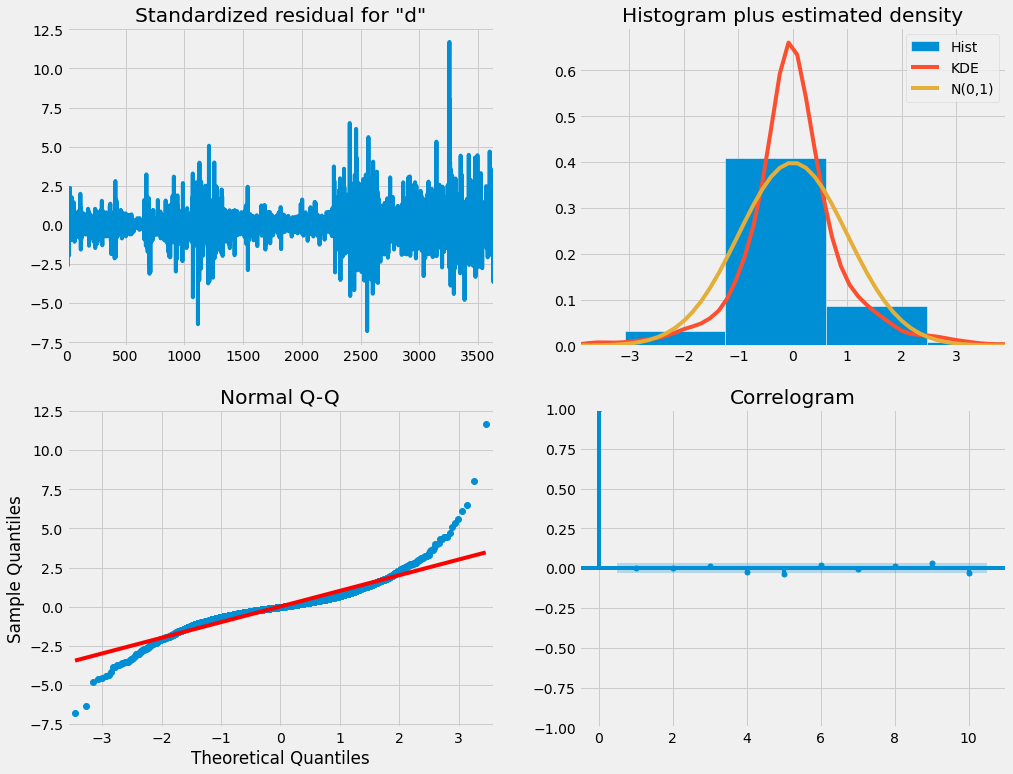

In [421]:
fit.plot_diagnostics(figsize=(15,12))
plt.show()

Como se puede ver en el **summary** del punto anterior el modelo no cumple la normalidad en los errores, se intentaron varios modelos pero ninguno cumple normalidad, a pesar de esto el modelo se puede usar pero teniendo en cuenta que no se deben realizar predicciones muchos dias hacia el futuro. 

## 6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.



In [422]:
df = df.dropna().reset_index(drop = True)

Creo la variable **pct_change** que es el cambio porcentual entre el precio del dia actual vs el precio de hace 7 dias.

In [423]:
df["pct_change_1"] = df.petroleo.pct_change(periods = 1)
df["pct_change_2"] = df.petroleo.pct_change(periods = 2)
df["pct_change_3"] = df.petroleo.pct_change(periods = 3)
df["pct_change_4"] = df.petroleo.pct_change(periods = 4)

In [424]:
df = df.dropna().reset_index(drop = True)

In [425]:
df_len = df.shape[0]
df_len # numero de filas

3633

In [426]:
train = df[:(df_len - 10)]
test = df[(df_len - 10):]
test

,fecha,petroleo,dolar,pct_change_1,pct_change_2,pct_change_3,pct_change_4
3623,2022-02-24,99.08,3913.79,0.023131,0.059226,0.065720,0.045037
3624,2022-02-25,97.93,3940.20,-0.011607,0.011256,0.046932,0.053351
3625,2022-03-01,104.97,3910.28,0.071888,0.059447,0.083953,0.122194
3626,2022-03-02,112.93,3901.62,0.075831,0.153171,0.139786,0.166150
3627,2022-03-03,110.46,3862.95,-0.021872,0.052301,0.127949,0.114857
3628,2022-03-04,118.11,3771.77,0.069256,0.045869,0.125179,0.206066
3629,2022-03-08,127.98,3813.41,0.083566,0.158609,0.133268,0.219205
3630,2022-03-09,111.14,3787.18,-0.131583,-0.059013,0.006156,-0.015851
3631,2022-03-10,109.33,3746.43,-0.016286,-0.145726,-0.074337,-0.010230
3632,2022-03-11,112.67,3786.00,0.030550,0.013766,-0.119628,-0.046059


In [427]:
test

,fecha,petroleo,dolar,pct_change_1,pct_change_2,pct_change_3,pct_change_4
3623,2022-02-24,99.08,3913.79,0.023131,0.059226,0.065720,0.045037
3624,2022-02-25,97.93,3940.20,-0.011607,0.011256,0.046932,0.053351
3625,2022-03-01,104.97,3910.28,0.071888,0.059447,0.083953,0.122194
3626,2022-03-02,112.93,3901.62,0.075831,0.153171,0.139786,0.166150
3627,2022-03-03,110.46,3862.95,-0.021872,0.052301,0.127949,0.114857
3628,2022-03-04,118.11,3771.77,0.069256,0.045869,0.125179,0.206066
3629,2022-03-08,127.98,3813.41,0.083566,0.158609,0.133268,0.219205
3630,2022-03-09,111.14,3787.18,-0.131583,-0.059013,0.006156,-0.015851
3631,2022-03-10,109.33,3746.43,-0.016286,-0.145726,-0.074337,-0.010230
3632,2022-03-11,112.67,3786.00,0.030550,0.013766,-0.119628,-0.046059


Utilizaremos solo 10 datos (2 semanas bursatiles) para el conjunto de prueba, ya que estos modelos usualmente no se usan para predecir muchos días en el futuro debido a la volatilidad, eventos inesperados y manipulación que estas series presentan.



Los datos de entrenamiento tienen 3623 filas (0 a 3622), los datos de prueba tienen 10 filas (3623 a 3632). 

## 7. Encuentre un modelo con la función auto_arima para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.


In [428]:
exo_var = ["petroleo", "pct_change_1", "pct_change_2", "pct_change_3", "pct_change_4"]
fit_X = pmd.arima.auto_arima(y = train["dolar"], X = train[exo_var])

In [429]:
fit_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3623
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -16452.799
Date:                Tue, 08 Nov 2022   AIC                          32921.599
Time:                        18:06:14   BIC                          32971.157
Sample:                             0   HQIC                         32939.255
                               - 3623                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
petroleo        -3.5146      0.313    -11.212      0.000      -4.129      -2.900
pct_change_1   161.3761     10.577     15.258      0.000     140.646     182.106
pct_change_2    42.2280     10.307      4.097      0.000      22.027      62.429
pct_change_3    -7.5367      9.736     -0.774      0.439     -26.618      11.545
pct_change_4   -34.8202     10.024     -3.474      0.001     -54.467     -15.173
ma.L1            0.1281      0.010     12.359      0.000       0.108       0.148
ma.L2           -0.0378      0.010     -3.606      0.000      -0.058      -0.017
sigma2         516.4143      5.857     88.174      0.000     504.935     527.893
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15891.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.64   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Se puede observar que todas parecen ser significativas menos el cambio porcentual tres dias atras.

In [430]:
pred_X, pred_ci = fit_X.predict(n_periods=10, X = test[exo_var], return_conf_int=True)

A continuación se observan los 7 valores al futuro predichos por el modelo.

In [431]:
print(pred_X)

3623    3921.755556
3624    3918.472402
3625    3906.562766
3626    3881.229491
3627    3871.759264
3628    3856.152019
3629    3828.014841
3630    3852.433229
3631    3874.150057
3632    3878.293465
dtype: float64


## 8. Realice un diagnóstico del modelo y saque conclusiones.

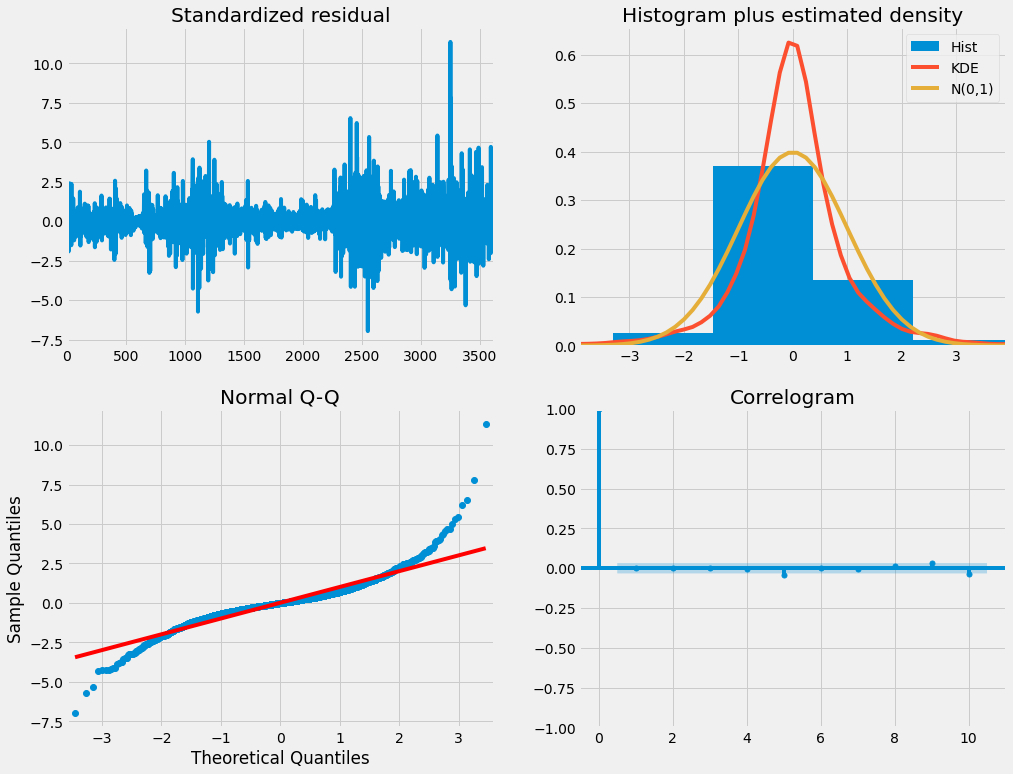

In [432]:
fit_X.plot_diagnostics(figsize=(15,12))
plt.show()

In [433]:
sm.stats.acorr_ljungbox(fit_X.resid())

,lb_stat,lb_pvalue
1,0.009237,0.923435
2,1.059222,0.588834
3,1.378478,0.710587
4,1.454721,0.834631
5,1.560442,0.905991
6,1.664220,0.947850
7,1.665275,0.976031
8,1.665276,0.989612
9,1.933196,0.992480
10,2.095771,0.995552


Como se puede observar en el punto anterior se rechaza la normalidad de los errores y ademas se observa que no hay correlacion entre los errores del Lag 1 al 10.

## 9 . Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

In [434]:
pred_no_X = fit.predict(start = 3623, end = 3632)#3626 a 3632

- pred_X = Predicción hecha con variables exógenas.
- pred_no_X = Predicción hecha sin variables exógenas
- test.dolar = Valor real de la serie de prueba

In [435]:
train

,fecha,petroleo,dolar,pct_change_1,pct_change_2,pct_change_3,pct_change_4
0,2002-10-17,27.97,2857.13,-0.021344,-0.000715,0.008291,-0.005688
1,2002-10-18,27.84,2853.90,-0.004648,-0.025892,-0.005359,0.003605
2,2002-10-22,26.43,2791.46,-0.050647,-0.055059,-0.075227,-0.055734
3,2002-10-23,26.51,2758.76,0.003027,-0.047773,-0.052199,-0.072428
4,2002-10-24,26.46,2744.32,-0.001886,0.001135,-0.049569,-0.053986
...,...,...,...,...,...,...,...
3618,2022-02-15,93.28,3938.97,-0.012283,0.020457,0.018897,0.027539
3619,2022-02-16,94.81,3946.88,0.016402,0.003918,0.037195,0.035609
3620,2022-02-17,92.97,3963.72,-0.019407,-0.003323,-0.015565,0.017066
3621,2022-02-18,93.54,3953.26,0.006131,-0.013395,0.002787,-0.009530


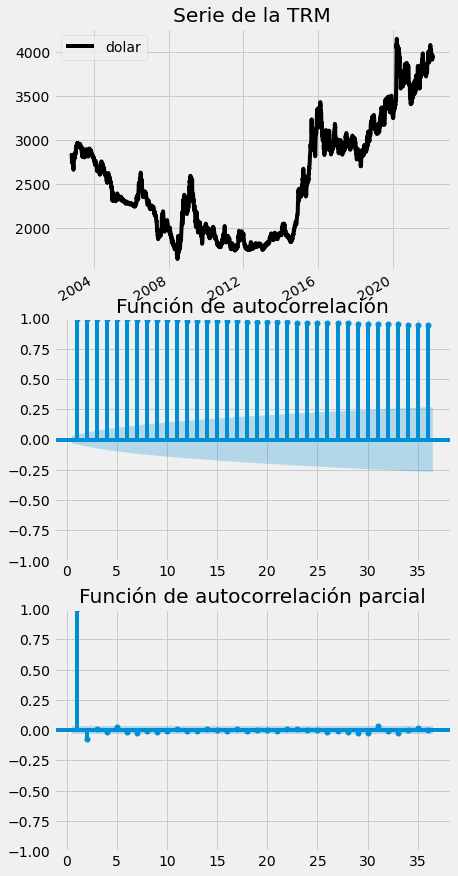

In [440]:
fig, ax = plt.subplots(3,1,figsize=(7,15))
fig.tight_layout(pad=2.5)
train.plot(ax=ax[0], x = "fecha", y = "dolar", title = "Serie de la TRM", xlabel="", color="black")
plot_acf(df.dolar, zero = False, title = "Función de autocorrelación", ax=ax[1])
plot_pacf(df.dolar, method="ywm", zero = False, title = "Función de autocorrelación parcial", ax=ax[2])
fig.show()

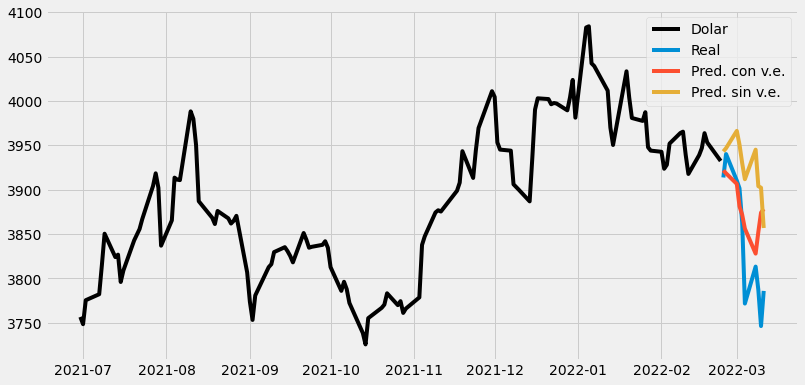

In [474]:
plt.figure(figsize=(12,6))
plt.plot(train[3500:].fecha, train[3500:].dolar, label = "Dolar", linestyle="-", color = "black")
plt.plot(test.fecha, test.dolar, label = "Real", linestyle="-")
plt.plot(test.fecha, pred_X, label = "Pred. con v.e.", linestyle="-")
plt.plot(test.fecha, pred_no_X, label = "Pred. sin v.e.", linestyle="-")
plt.legend()
plt.show()

In [475]:
pred_no_X

3623    3943.112559
3624    3946.789943
3625    3966.259805
3626    3950.728760
3627    3929.911857
3628    3911.803527
3629    3945.117748
3630    3903.994145
3631    3902.269502
3632    3856.864507
Name: predicted_mean, dtype: float64

In [476]:
pred_X

3623    3921.755556
3624    3918.472402
3625    3906.562766
3626    3881.229491
3627    3871.759264
3628    3856.152019
3629    3828.014841
3630    3852.433229
3631    3874.150057
3632    3878.293465
dtype: float64

In [477]:
test.dolar

3623    3913.79
3624    3940.20
3625    3910.28
3626    3901.62
3627    3862.95
3628    3771.77
3629    3813.41
3630    3787.18
3631    3746.43
3632    3786.00
Name: dolar, dtype: float64

In [478]:
MSE_X = mean_squared_error(test.dolar, pred_X)
MSE_no_X = mean_squared_error(test.dolar, pred_no_X)
MAPE_X = mean_absolute_percentage_error(test.dolar, pred_X)
MAPE_no_X = mean_absolute_percentage_error(test.dolar, pred_no_X)

print("Root Mean Square Error:")
print("- con variables exógenas " + str(math.sqrt(MSE_X)))
print("- sin variables exógenas " + str(math.sqrt(MSE_no_X)))

print("\n")
print("MAPE:")
print("- con variables exógenas " + str(MAPE_X*100))
print("- sin variables exógenas " + str(MAPE_no_X*100))

Root Mean Square Error:
- con variables exógenas 61.20852850850137
- sin variables exógenas 95.3111386778927


MAPE:
- con variables exógenas 1.1790743099220422
- sin variables exógenas 2.162255385704585


## 10. Saque conclusiones.

Se puede ver que con el **modelo entrenado inicialmente (sin variables exógenas)** se obtiene un **RMSE de 95.31 y un MAPE de 2.16**, mientras que cuando se consideran las **variables exógenas** de precio de petróleo y cambio porcentual respecto a días anteriores, se observa un **RMSE de 61.20 y un MAPE de 1.17**, esto es una reducción en el error de **alrededor del 50%**.

Si se tiene en cuenta que el dólar para la cola de esta base de datos toma valores alrededor de 3800, un RMSE de 61 se puede considerar aceptable o muy buena, depende mucho del uso que se le vaya a dar a estas predicciones. También se puede observar que agregar las variables exógenas si tuvo mejoría en las predicciones.



### Enunciados Punto 2

Vaya al sitio web del DANE haciendo click [AQUÍ](https://www.dane.gov.co/), luego hacer click en  __Estadísticas por tema__, busque en la columna de __Economía__ el item __Construcción__ y hacer click en __Estadísticas de cemento gris (ECG)__. Vaya a __Información adicional__ y hacer click en __Información Histórica__, luego hacer click en __Anexos__  de Septiembre en la tabla del Año 2022. En este punto se descarga automáticamente una base de datos en Excel

1. Lea la BD que se encuentra en el  Anexo 1.

2. Realice un gráfico de puntos XY de la serie Producción en Toneladas versus Despachos Nacionales en Toneladas.

3. Realice un gráfico donde aparezcan ambas series de tiempo a lo largo del tiempo.

4. Mediante la función __auto_arima__ ajuste un modelo SARIMA para ajustar la Producción utilizando como covariable los Despachos Nacionales.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Realice predicciones para un año.

7. Saque conclusiones.

# Punto 2

## 1)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import janitor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from patsy import dmatrix, dmatrices
import pmdarima as pmd
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')
%matplotlib inline

### Limpieza de la Base de Datos:

In [2]:
db = pd.read_excel("Data/Anexos_ECG_sep22.xlsx", sheet_name="Anexo 1 ", 
                   skiprows=8, index_col=None)
db.shape

(171, 11)

In [3]:
db.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Producción,Despachos Nacionales,Anual,Año corrido,Doce meses,Anual .1,Año corrido.1,Doce meses.1
0,2009,NaN,Abr,757117.0,678660.6485,(-),(-),(-),(-),(-),(-)
1,NaN,NaN,May,816612.0,695754.5795,(-),(-),(-),(-),(-),(-)
2,NaN,NaN,Jun,734996.0,635398.9190,(-),(-),(-),(-),(-),(-)
3,NaN,NaN,Jul,767767.0,741963.0250,(-),(-),(-),(-),(-),(-)
4,NaN,NaN,Ago,790129.0,700399.2785,(-),(-),(-),(-),(-),(-)


In [4]:
db.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Producción,Despachos Nacionales,Anual,Año corrido,Doce meses,Anual .1,Año corrido.1,Doce meses.1
166,(-) Sin información,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,p Cifra provisional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Nota: La producción total de cemento gris cont...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,Nota aclaratoria: Se realiza ajuste en la vari...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,Actualizado el 28 de octubre 2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
db = db[:-9]
db.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Producción,Despachos Nacionales,Anual,Año corrido,Doce meses,Anual .1,Año corrido.1,Doce meses.1
157,NaN,NaN,May,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026
158,NaN,NaN,Jun,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781
159,NaN,NaN,Jul,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938
160,NaN,NaN,Ago,1.233964e+06,1.189913e+06,6.070958,8.385229,6.969786,8.395314,6.247258,5.157145
161,NaN,NaN,Sep,1.279916e+06,1.188171e+06,4.130198,7.867065,6.706283,2.083653,5.741907,5.078673


In [6]:
db.shape

(162, 11)

In [7]:
db = db.clean_names()
db.columns

Index(['unnamed_0', 'unnamed_1', 'unnamed_2', 'produccion',
       'despachos_nacionales', 'anual_', 'ano_corrido', 'doce_meses',
       'anual_1', 'ano_corrido_1', 'doce_meses_1'],
      dtype='object')

In [8]:
#drop column 1 = unamed_2 
db.drop(['unnamed_1'], axis=1, inplace=True)

In [9]:
db.rename(columns={'unnamed_0':'year', 'unnamed_2':'month'}, inplace=True)

In [10]:
db.dtypes

year                     object
month                    object
produccion              float64
despachos_nacionales    float64
anual_                   object
ano_corrido              object
doce_meses               object
anual_1                  object
ano_corrido_1            object
doce_meses_1             object
dtype: object

In [11]:
year = db.year.iloc[0]

for i in range(1, db.shape[0]):
    if db.year.iloc[i] is np.nan:
        db.year.iloc[i] = year
    else:
        year = db.year.iloc[i]

In [12]:
db.year

0      2009
1      2009
2      2009
3      2009
4      2009
       ... 
157    2022
158    2022
159    2022
160    2022
161    2022
Name: year, Length: 162, dtype: object

In [13]:
replace = {'Ene' : '01', 'Feb' : '02', 'Mar' :'03', 'Abr' : '04', 'May' : '05',
        'Jun' : '06', 'Jul' : '07', 'Ago' : '08', 'Sep' : '09', 'Oct' : '10',
        'Nov' : '11', 'Dic' : '12'}

for i in range(db.shape[0]):
    db.month.iloc[i] = replace[db.month.iloc[i]]

In [14]:
db.month

0      04
1      05
2      06
3      07
4      08
       ..
157    05
158    06
159    07
160    08
161    09
Name: month, Length: 162, dtype: object

In [15]:
db['date'] = db.month + "/" + db.year.astype(str)
db

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1,date
0,2009,04,7.571170e+05,6.786606e+05,(-),(-),(-),(-),(-),(-),04/2009
1,2009,05,8.166120e+05,6.957546e+05,(-),(-),(-),(-),(-),(-),05/2009
2,2009,06,7.349960e+05,6.353989e+05,(-),(-),(-),(-),(-),(-),06/2009
3,2009,07,7.677670e+05,7.419630e+05,(-),(-),(-),(-),(-),(-),07/2009
4,2009,08,7.901290e+05,7.003993e+05,(-),(-),(-),(-),(-),(-),08/2009
...,...,...,...,...,...,...,...,...,...,...,...
157,2022,05,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026,05/2022
158,2022,06,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781,06/2022
159,2022,07,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938,07/2022
160,2022,08,1.233964e+06,1.189913e+06,6.070958,8.385229,6.969786,8.395314,6.247258,5.157145,08/2022


In [16]:

db.date = pd.to_datetime(db.date, format="%m/%Y")

## 2) Realice un gráfico de puntos XY de la serie Producción en Toneladas versus Despachos Nacionales en Toneladas.

<Figure size 720x720 with 0 Axes>

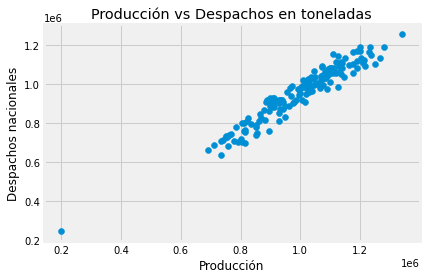

In [17]:
plt.figure(figsize=(10,10))

fig, ax = plt.subplots()
ax.scatter(db.produccion, db.despachos_nacionales)
ax.set_xlabel('Producción')
ax.set_ylabel('Despachos nacionales')
ax.set_title('Producción vs Despachos en toneladas')

plt.show()

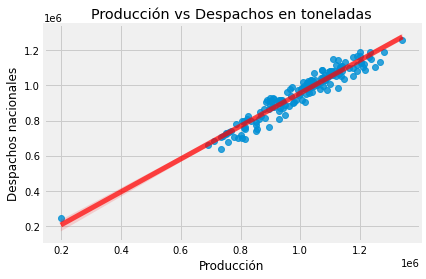

In [18]:
sns.regplot(x=db.produccion, y=db.despachos_nacionales, line_kws={"color":"r", "alpha":0.7,"lw":5})
plt.title('Producción vs Despachos en toneladas')
plt.xlabel('Producción')
plt.ylabel('Despachos nacionales')
plt.show()

Se puede observar una fuente relación lineal entre la produccion y los depachos nacionales.

## 3) Realice un gráfico donde aparezcan ambas series de tiempo a lo largo del tiempo.

In [19]:
serie = db.copy()
serie = db.copy()
serie.set_index("date", inplace=True)
serie

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1
date,,,,,,,,,,
2009-04-01,2009,04,7.571170e+05,6.786606e+05,(-),(-),(-),(-),(-),(-)
2009-05-01,2009,05,8.166120e+05,6.957546e+05,(-),(-),(-),(-),(-),(-)
2009-06-01,2009,06,7.349960e+05,6.353989e+05,(-),(-),(-),(-),(-),(-)
2009-07-01,2009,07,7.677670e+05,7.419630e+05,(-),(-),(-),(-),(-),(-)
2009-08-01,2009,08,7.901290e+05,7.003993e+05,(-),(-),(-),(-),(-),(-)
...,...,...,...,...,...,...,...,...,...,...
2022-05-01,2022,05,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026
2022-06-01,2022,06,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781
2022-07-01,2022,07,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938


<AxesSubplot:title={'center':'Serie Producción'}, xlabel='date'>

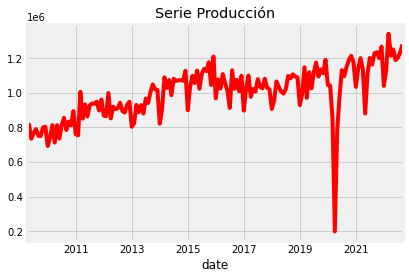

In [20]:
serie.produccion.plot(title="Serie Producción", color="red")

<AxesSubplot:title={'center':'Serie Despachos Nacionales'}, xlabel='date'>

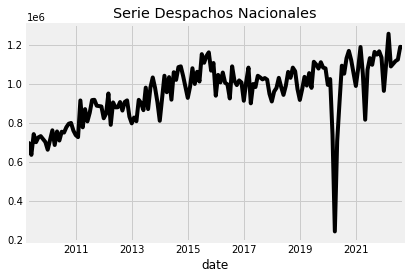

In [21]:
serie.despachos_nacionales.plot(title="Serie Despachos Nacionales", color="black")

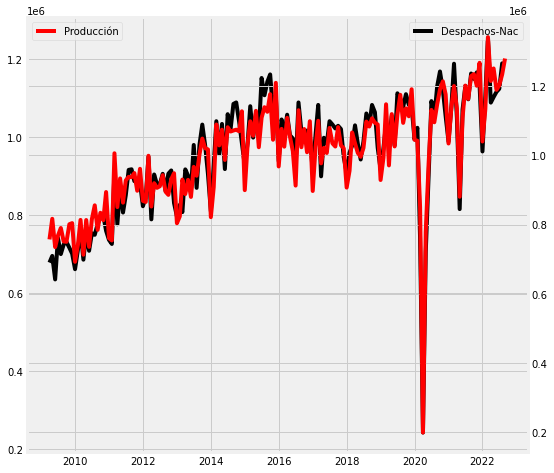

In [22]:
prod = serie.produccion.values
despa = serie.despachos_nacionales.values
date = db.date.values

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
#ax2.set_ylim(0, 150)

ax1.plot(date, despa, color="black", label="Despachos-Nac")
ax2.plot(date, prod, color="red", label="Producción")
ax1.legend(loc="upper right")
#ax2.legend(loc="upper left")
plt.legend()
plt.show()

## 4) Mediante la función auto_arima ajuste un modelo SARIMA para ajustar la Producción utilizando como covariable los Despachos Nacionales.

In [23]:
matriz = dmatrix(serie.despachos_nacionales)
matriz

DesignMatrix with shape (162, 1)
  despachos_nacionales
           678660.6485
           695754.5795
           635398.9190
           741963.0250
           700399.2785
           725187.0710
           731458.2880
           716674.8705
           701444.9590
           661697.3840
           711607.6750
           761517.1535
           686064.2700
           755619.3885
           708921.5525
           754067.7425
           749920.7980
           777478.7460
           795135.3736
           799131.1960
           760219.9770
           736901.4900
           726418.9520
           914686.7650
           776826.3345
           870177.8645
           807107.1370
           851728.5790
           916550.8915
           918049.3045
  [132 rows omitted]
  Terms:
    'despachos_nacionales' (column 0)
  (to view full data, use np.asarray(this_obj))

In [24]:
model = pmd.auto_arima(serie.produccion, X=matriz, stepwise=False,
                      information_criterion="bic", seasonal=True,test="adf",
                       max_p=3, max_q=3, m=12)

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  162
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1912.182
Date:                             Tue, 08 Nov 2022   AIC                           3836.365
Time:                                     19:42:22   BIC                           3854.853
Sample:                                 04-01-2009   HQIC                          3843.872
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    535.0844    411.947      1.299      0.194    -272.317    1342.486
x1             0.9966      0.021     47.742      0.000       0.956       1.037
ma.L1         -1.1654      0.105    -11.119      0.000      -1.371      -0.960
ma.L2          0.2639      0.105      2.509      0.012       0.058       0.470
ar.S.L12       0.4245      0.099      4.301      0.000       0.231       0.618
sigma2      1.502e+09    9.8e-05   1.53e+13      0.000     1.5e+09     1.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.06
Prob(Q):                              1.00   Prob(JB):                         0.36
Heteroskedasticity (H):               0.83   Skew:                             0.17
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+29. Standard errors may be unstable.
"""

In [26]:
model = SARIMAX(serie.produccion, exog=matriz, order=(0,1,2), seasonal_order=(1, 0, 0, 12)).fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23011D+01    |proj g|=  9.80884D-01

At iterate    5    f=  1.18023D+01    |proj g|=  8.70677D-02

At iterate   10    f=  1.17948D+01    |proj g|=  7.84063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   8.783D-06   1.179D+01
  F =   11.794769578615000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          produccion   No. Observations:                  162
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1910.753
Date:                             Tue, 08 Nov 2022   AIC                           3831.505
Time:                                     19:42:22   BIC                           3846.912
Sample:                                 04-01-2009   HQIC                          3837.761
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0056      0.023     44.155      0.000       0.961       1.050
ma.L1         -1.1774      0.106    -11.106      0.000      -1.385      -0.970
ma.L2          0.2492      0.111      2.253      0.024       0.032       0.466
ar.S.L12       0.4424      0.095      4.637      0.000       0.255       0.629
sigma2      1.502e+09   5.57e-12    2.7e+20      0.000     1.5e+09     1.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.95   Prob(JB):                         0.36
Heteroskedasticity (H):               0.92   Skew:                             0.15
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+37. Standard errors may be unstable.
"""

## 5) Realice un diagnóstico del modelo y saque conclusiones.



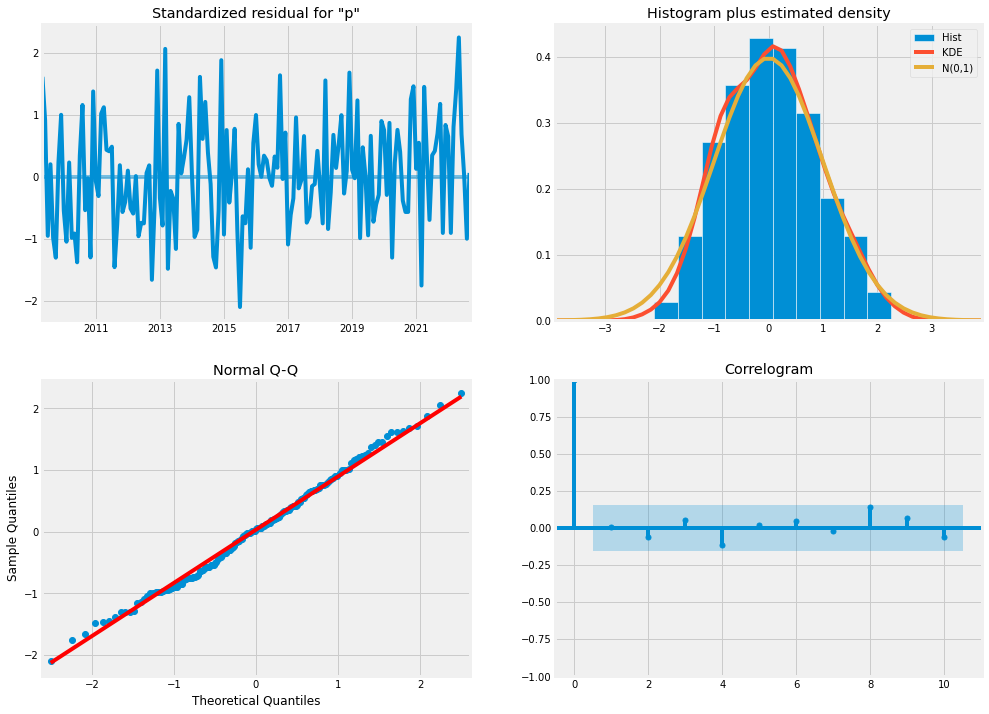

In [27]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          produccion   No. Observations:                  162
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1910.753
Date:                             Tue, 08 Nov 2022   AIC                           3831.505
Time:                                     19:42:23   BIC                           3846.912
Sample:                                 04-01-2009   HQIC                          3837.761
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0056      0.023     44.155      0.000       0.961       1.050
ma.L1         -1.1774      0.106    -11.106      0.000      -1.385      -0.970
ma.L2          0.2492      0.111      2.253      0.024       0.032       0.466
ar.S.L12       0.4424      0.095      4.637      0.000       0.255       0.629
sigma2      1.502e+09   5.57e-12    2.7e+20      0.000     1.5e+09     1.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.95   Prob(JB):                         0.36
Heteroskedasticity (H):               0.92   Skew:                             0.15
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+37. Standard errors may be unstable.
"""

Con el "mejor" modelo calculado con el auto-rima con los ordenes (0, 1, 2)x(1, 0, 1, 12) se cumple estacionariadad y normalidad para ellos se observa:

- Para la prueba de **Ljung-Box** con un p-valor = 0.95 > 0.05 hay estarcionaridad en la serie.

- Para la prueba de **Jarque-Bera** con un p-valor = 0.36 > 0.05 hay normalidad en la serie. 

## 6) Realice predicciones para un año.



In [29]:
train, test = train_test_split(serie, test_size = 0.05, shuffle = False)

In [30]:
train

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1
date,,,,,,,,,,
2009-04-01,2009,04,7.571170e+05,6.786606e+05,(-),(-),(-),(-),(-),(-)
2009-05-01,2009,05,8.166120e+05,6.957546e+05,(-),(-),(-),(-),(-),(-)
2009-06-01,2009,06,7.349960e+05,6.353989e+05,(-),(-),(-),(-),(-),(-)
2009-07-01,2009,07,7.677670e+05,7.419630e+05,(-),(-),(-),(-),(-),(-)
2009-08-01,2009,08,7.901290e+05,7.003993e+05,(-),(-),(-),(-),(-),(-)
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,2021,08,1.163339e+06,1.097753e+06,6.183691,24.500757,16.641215,4.341849,24.688655,16.138787
2021-09-01,2021,09,1.229150e+06,1.163919e+06,7.068128,22.080215,16.795706,2.892069,21.563065,15.882596
2021-10-01,2021,10,1.234918e+06,1.150044e+06,3.738473,19.771739,16.631893,-1.631075,18.569294,15.111279


In [31]:
test

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1
date,,,,,,,,,,
2022-01-01,2022,01,1.040161e+06,9.638894e+05,0.562303,0.562303,16.601643,-2.548578,-2.548578,15.92138
2022-02-01,2022,02,1.133914e+06,1.106900e+06,-0.521894,-0.006105,15.598114,2.562758,0.118474,15.604434
2022-03-01,2022,03,1.341585e+06,1.257125e+06,11.767202,4.181705,13.452899,5.72837,2.166224,11.757584
2022-04-01,2022,04,1.214954e+06,1.089207e+06,6.961267,4.881695,6.011502,3.652625,2.528778,4.859489
2022-05-01,2022,05,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026
2022-06-01,2022,06,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781
2022-07-01,2022,07,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938
2022-08-01,2022,08,1.233964e+06,1.189913e+06,6.070958,8.385229,6.969786,8.395314,6.247258,5.157145
2022-09-01,2022,09,1.279916e+06,1.188171e+06,4.130198,7.867065,6.706283,2.083653,5.741907,5.078673


In [32]:
matriz = dmatrix(test.despachos_nacionales)

In [33]:
start = len(train)
end = len(train) + len(test) -1

pred = model.get_prediction(start, end, exog=matriz, dinamyc=False)
pred_ci = pred.conf_int(alpha=0.5)
pred_ci

,lower produccion,upper produccion
2022-01-01,9.887709e+05,1.041059e+06
2022-02-01,1.142756e+06,1.195044e+06
2022-03-01,1.284239e+06,1.336527e+06
2022-04-01,1.134088e+06,1.186376e+06
2022-05-01,1.137966e+06,1.190254e+06
2022-06-01,1.136606e+06,1.188895e+06
2022-07-01,1.176063e+06,1.228351e+06
2022-08-01,1.246425e+06,1.298713e+06
2022-09-01,1.251284e+06,1.303572e+06


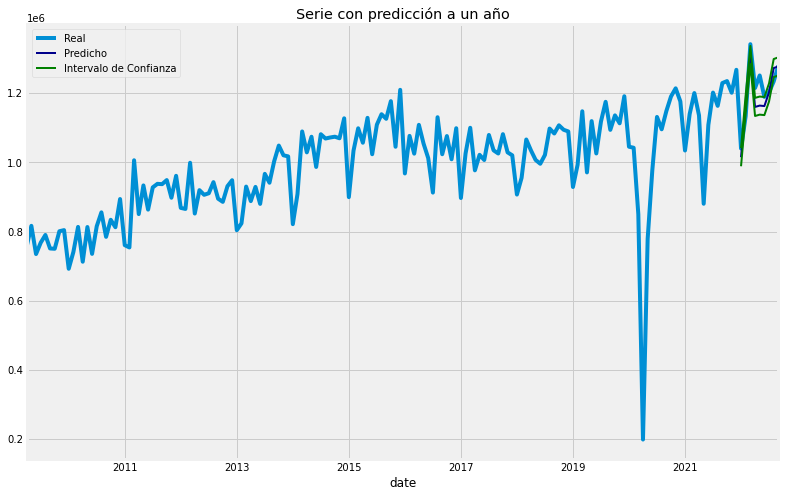

In [34]:
plt.figure(figsize=(12,8))  
serie.produccion.plot()
pred.predicted_mean.plot(color="darkblue", linewidth = 2, title = "Serie con predicción a un año")
pred_ci.iloc[:,0].plot(color="green", linewidth = 2)
pred_ci.iloc[:,1].plot(color="green", linewidth = 2)

plt.legend(["Real", "Predicho", "Intervalo de Confianza"])
plt.show()

## 7) Saque conclusiones.

Las predicciones realizadas para el conjunto de datos de prueba con el modelo teniendo presente como variable exógena los despachos nacionales son relativamente buenas. 
Por otra parte se sugiere modelar la intervención presenta en el año 2020 por causa de la pandemia.